In [2]:
enable_wandb=True
if enable_wandb:
    import wandb

In [3]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: deepakpokkalla. Use `wandb login --relogin` to force relogin


True

In [4]:
import os 
import pdb
import torch 
import pandas 

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.4.0+cu124


In [5]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.scatter(z[:,0],z[:,1],s=70,c=color,cmap="Set2")

def embedding_to_wandb(h, color, key="embedding"):
    num_components = h.shape[-1]
    df = pandas.DataFrame(data=h.detach().cpu().numpy(),
                        columns=[f"c_{i}" for i in range(num_components)])
    df["target"] = color.detach().cpu().numpy().astype("str")
    cols = df.columns.tolist()
    df = df[cols[-1:] + cols[:-1]]
    wandb.log({key: df})

In [6]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='../datasets/Planetoid', name="Cora", transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}')
print(f'# features: {dataset.num_features}')
print(f'# classes: {dataset.num_classes}')
print(f'# graphs: {len(dataset)}')


Dataset: Cora()
# features: 1433
# classes: 7
# graphs: 1


In [7]:
data = dataset[0]

print()
print(data)
print()

# gather info
print(f'# nodes: {data.num_nodes}')
print(f'# edges: {data.num_edges}')
print(f'avg node degree: {data.num_edges/data.num_nodes:.2f}')
print(f'# training nodes: {data.train_mask.sum()}')
print(f'training node label rate: {int(data.train_mask.sum())/data.num_nodes:.2f}')
print(f'has isolated nodes: {data.has_isolated_nodes()}')
print(f'has self-loops: {data.has_self_loops()}')
print(f'is undirected: {data.is_undirected()}')


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

# nodes: 2708
# edges: 10556
avg node degree: 3.90
# training nodes: 140
training node label rate: 0.05
has isolated nodes: False
has self-loops: False
is undirected: True


#### Train an MLP

In [8]:
import torch 
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features,hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)
    
    def forward(self,x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

In [9]:
if enable_wandb:
    wandb.init(project='pyg-colab-node-classification')
    summary = dict()
    summary["data"] = dict()
    summary["data"]["num_features"] = dataset.num_features
    summary["data"]["num_classes"] = dataset.num_classes
    summary["data"]["num_nodes"] = data.num_nodes
    summary["data"]["num_edges"] = data.num_edges 
    summary["data"]["has_isolated_nodes"] = data.has_isolated_nodes()
    summary["data"]["has_self_nodes"] = data.has_self_loops()
    summary["data"]["is_undirected"] = data.is_undirected()
    summary["data"]["num_training_nodes"] = data.train_mask.sum()
    wandb.summary = summary

model: MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


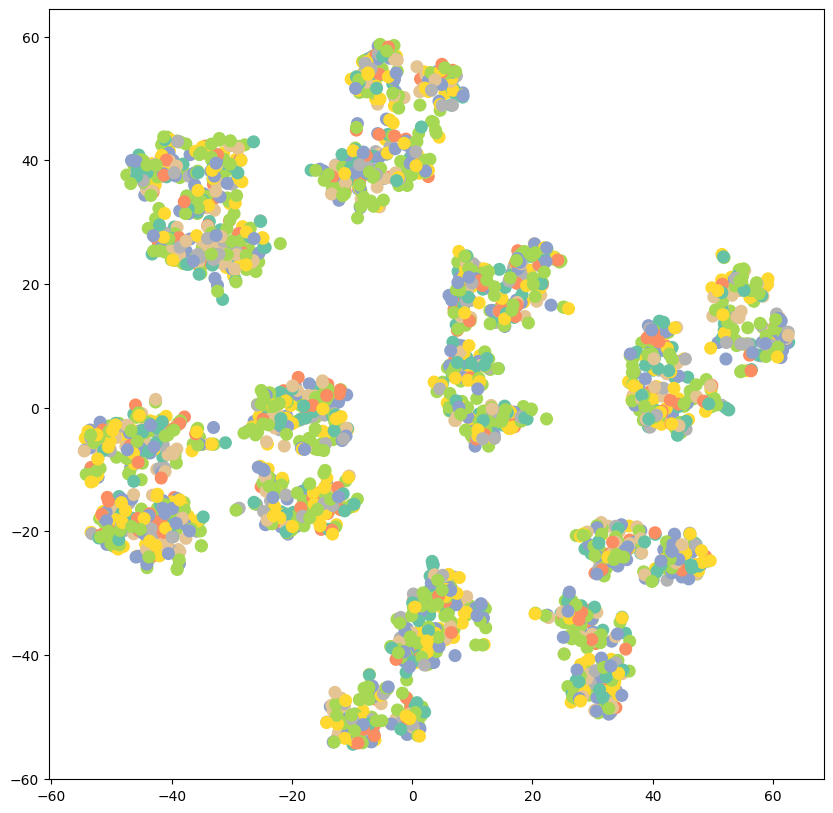

In [10]:
model = MLP(16)
print(f'model: {model}')

with torch.no_grad():
    out = model(data.x)

# if enable_wandb:
#     embedding_to_wandb(out, color=data.y, key="mlp/embedding/init")
# else:
#     visualize(out, data.y)

embedding_to_wandb(out, color=data.y, key="mlp/embedding/init")
visualize(out, data.y)


In [11]:
# out.shape, data.y.min(), data.y.max()

In [12]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x)
    loss = criterion(out[data.train_mask],data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)
    correct = pred[data.test_mask] == data.y[data.test_mask]
    acc = int(correct.sum())/int(data.test_mask.sum())
    return acc

for epoch in range(1,201):
    loss = train()
    if enable_wandb:
        wandb.log({"mlp/loss": loss})
    print(f'Epoch: {epoch:03d}, Loss:{loss:.4f}')


Epoch: 001, Loss:1.9616
Epoch: 002, Loss:1.9564
Epoch: 003, Loss:1.9495
Epoch: 004, Loss:1.9419
Epoch: 005, Loss:1.9369
Epoch: 006, Loss:1.9244
Epoch: 007, Loss:1.9196
Epoch: 008, Loss:1.9131
Epoch: 009, Loss:1.9019
Epoch: 010, Loss:1.8895
Epoch: 011, Loss:1.8737
Epoch: 012, Loss:1.8616
Epoch: 013, Loss:1.8539
Epoch: 014, Loss:1.8458
Epoch: 015, Loss:1.8197
Epoch: 016, Loss:1.8194
Epoch: 017, Loss:1.8027
Epoch: 018, Loss:1.7732
Epoch: 019, Loss:1.7733
Epoch: 020, Loss:1.7491
Epoch: 021, Loss:1.7472
Epoch: 022, Loss:1.7194
Epoch: 023, Loss:1.6962
Epoch: 024, Loss:1.6584
Epoch: 025, Loss:1.6668
Epoch: 026, Loss:1.6226
Epoch: 027, Loss:1.6333
Epoch: 028, Loss:1.6029
Epoch: 029, Loss:1.5534
Epoch: 030, Loss:1.5783
Epoch: 031, Loss:1.5381
Epoch: 032, Loss:1.5213
Epoch: 033, Loss:1.4926
Epoch: 034, Loss:1.4652
Epoch: 035, Loss:1.4754
Epoch: 036, Loss:1.4559
Epoch: 037, Loss:1.3932
Epoch: 038, Loss:1.3604
Epoch: 039, Loss:1.3321
Epoch: 040, Loss:1.3120
Epoch: 041, Loss:1.3279
Epoch: 042, Loss

In [13]:
test_acc = test()
out = model(data.x)
print(enable_wandb)
if enable_wandb:
    embedding_to_wandb(out, color=data.y, key="mlp/embedding/trained")
    wandb.summary["mlp/accuracy"]=test_acc
    wandb.log({"mlp/accuracy": test_acc})
else:
    visualize(out,data.y)

print(f'Test accuracy: {test_acc:.4f}')

True
Test accuracy: 0.6040


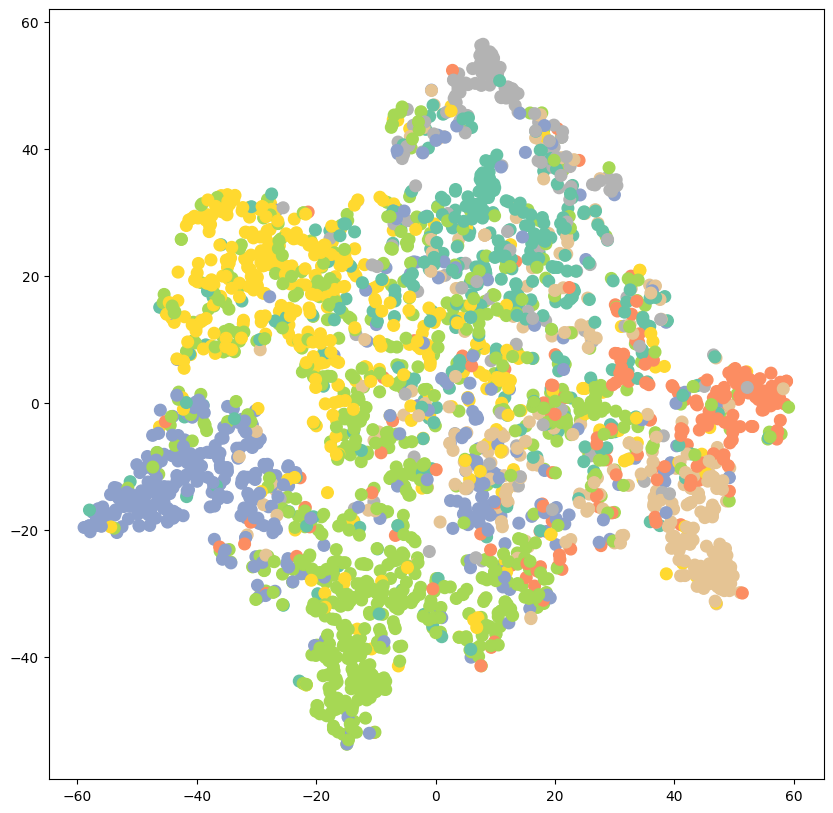

In [14]:
visualize(out,data.y)

#### Train a GNN

In [15]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)
    
    def forward(self,x,edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x,edge_index)
        return x

model = GCN(16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [16]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)

if enable_wandb:
    embedding_to_wandb(out, color=data.y, key="gcn/embedding/init")
else:
    visualize(out, data.y)

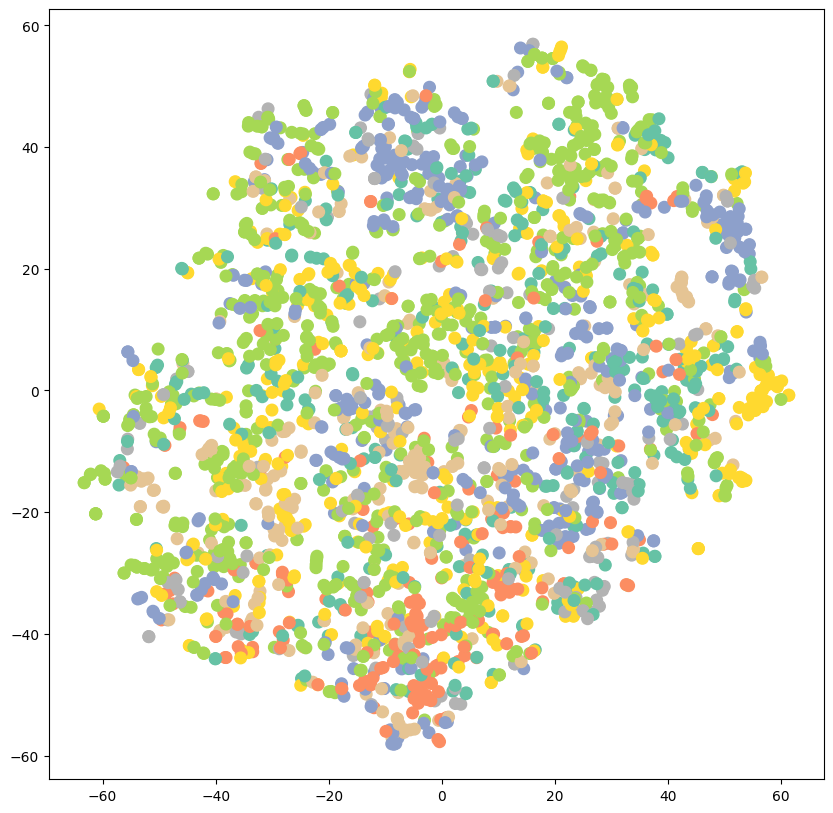

In [17]:
visualize(out, data.y)

In [18]:
model = GCN(16)
print(model)

if enable_wandb:
    wandb.watch(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask],data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

for epoch in range(1,101):
    loss=train()
    if enable_wandb:
        wandb.log({"gcn/loss": loss})
    print(f'Epoch: {epoch:03d}, Loss:{loss:.4f}')

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)
Epoch: 001, Loss:1.9452
Epoch: 002, Loss:1.9420
Epoch: 003, Loss:1.9360
Epoch: 004, Loss:1.9273
Epoch: 005, Loss:1.9155
Epoch: 006, Loss:1.9104
Epoch: 007, Loss:1.9083
Epoch: 008, Loss:1.9045
Epoch: 009, Loss:1.8889
Epoch: 010, Loss:1.8853
Epoch: 011, Loss:1.8911
Epoch: 012, Loss:1.8729
Epoch: 013, Loss:1.8683
Epoch: 014, Loss:1.8543
Epoch: 015, Loss:1.8562
Epoch: 016, Loss:1.8541
Epoch: 017, Loss:1.8370
Epoch: 018, Loss:1.8311
Epoch: 019, Loss:1.8142
Epoch: 020, Loss:1.8128
Epoch: 021, Loss:1.7928
Epoch: 022, Loss:1.7799
Epoch: 023, Loss:1.7850
Epoch: 024, Loss:1.7774
Epoch: 025, Loss:1.7683
Epoch: 026, Loss:1.7716
Epoch: 027, Loss:1.7451
Epoch: 028, Loss:1.7451
Epoch: 029, Loss:1.7238
Epoch: 030, Loss:1.7237
Epoch: 031, Loss:1.6777
Epoch: 032, Loss:1.6869
Epoch: 033, Loss:1.6664
Epoch: 034, Loss:1.6714
Epoch: 035, Loss:1.6688
Epoch: 036, Loss:1.6455
Epoch: 037, Loss:1.6142
Epoch: 038, Loss:1.6111
Epoch: 039, Loss:1.5671
Ep

In [19]:
test_acc = test()
print(f'test_acc: {test_acc}')

test_acc: 0.796


In [20]:
model.eval()

out = model(data.x, data.edge_index)

if enable_wandb:
    wandb.summary["gcn/accuracy"] = test_acc
    wandb.log({"gcn/accuracy": test_acc})
    embedding_to_wandb(out, color=data.y, key="gcn/embedding/trained")
    wandb.finish()
else:
    visualize(out, data.y)

gcn/accuracy,▁
gcn/loss,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▂▂▂▁
mlp/accuracy,▁
mlp/loss,█▇▇▇▇▆▅▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁
gcn/accuracy,0.796
gcn/loss,0.87055
mlp/accuracy,0.604
mlp/loss,0.46549


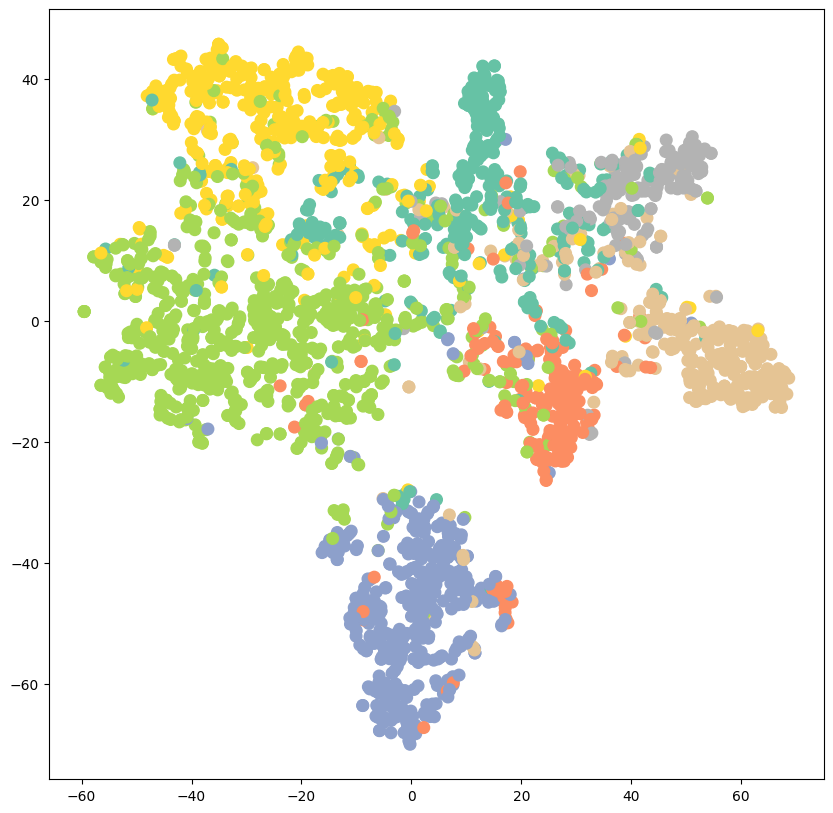

In [21]:
visualize(out, data.y)

### Using W&B Sweeps

In [27]:
wandb.login

<function wandb.sdk.wandb_login.login(anonymous: Optional[Literal['must', 'allow', 'never']] = None, key: Optional[str] = None, relogin: Optional[bool] = None, host: Optional[str] = None, force: Optional[bool] = None, timeout: Optional[int] = None, verify: bool = False) -> bool>

In [28]:
import tqdm

def agent_fn():
    wandb.init()
    model = GCN(hidden_channels=wandb.config.hidden_channels)
    wandb.watch(model)

    with torch.no_grad():
        out = model(data.x, data.edge_index)
        embedding_to_wandb(out, color=data.y, key="gcn/embedding/init")
    
    optimizer = torch.optim.Adam(model.parameters(), lr=wandb.config.lr, weight_decay=wandb.config.weight_decay)
    criterion = torch.nn.CrossEntropyLoss()

    def train():
          model.train()
          optimizer.zero_grad()  # Clear gradients.
          out = model(data.x, data.edge_index)  # Perform a single forward pass.
          loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
          loss.backward()  # Derive gradients.
          optimizer.step()  # Update parameters based on gradients.
          return loss

    def test():
          model.eval()
          out = model(data.x, data.edge_index)
          pred = out.argmax(dim=1)  # Use the class with highest probability.
          test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
          test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
          return test_acc

    for epoch in tqdm.tqdm(range(1, 101)):
        loss = train()
        wandb.log({"gcn/loss": loss})

    model.eval()

    out = model(data.x, data.edge_index)
    test_acc = test()
    wandb.summary["gcn/accuracy"] = test_acc
    wandb.log({"gcn/accuracy": test_acc})
    embedding_to_wandb(out, color=data.y, key="gcn/embedding/trained")
    wandb.finish()

In [29]:
sweep_config = {
    "name": "gcn-sweep",
    "method": "bayes",
    "metric": {
        "name": "gcn/accuracy",
        "goal": "maximize",
    },
    "parameters": {
        "hidden_channels": {
            "values": [8, 16, 32]
        },
        "weight_decay": {
            "distribution": "normal",
            "mu": 5e-4,
            "sigma": 1e-5,
        },
        "lr": {
            "min": 1e-4,
            "max": 1e-3
        }
    }
}

# Register the Sweep with W&B
sweep_id = wandb.sweep(sweep_config, project="pyg-node-classification")

Create sweep with ID: d99tj2ln
Sweep URL: https://wandb.ai/deepakpokkalla/pyg-node-classification/sweeps/d99tj2ln


In [31]:
wandb.agent(sweep_id, project="pyg-node-classification", function=agent_fn, count=50)

wandb: Agent Starting Run: zyr3bwf7 with config:
wandb: 	hidden_channels: 16
wandb: 	lr: 0.0005310691337424886
wandb: 	weight_decay: 0.000494558459845563


100%|██████████| 100/100 [00:00<00:00, 113.54it/s]


gcn/accuracy,▁
gcn/loss,█▇██▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▅▅▆▄▄▄▄▄▄▄▄▄▃▄▂▃▂▂▂▁
gcn/accuracy,0.656
gcn/loss,1.90796


wandb: Agent Starting Run: qe43lod3 with config:
wandb: 	hidden_channels: 8
wandb: 	lr: 0.0004708961638731445
wandb: 	weight_decay: 0.0004805592738921111


100%|██████████| 100/100 [00:00<00:00, 165.74it/s]


gcn/accuracy,▁
gcn/loss,████▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▁▁
gcn/accuracy,0.567
gcn/loss,1.91059


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ltpsffes with config:
wandb: 	hidden_channels: 16
wandb: 	lr: 0.0008657979315308059
wandb: 	weight_decay: 0.0005006181101825065


100%|██████████| 100/100 [00:01<00:00, 83.64it/s]


gcn/accuracy,▁
gcn/loss,█▇▇█▇▇▇▇▇▇▆▇▆▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▄▄▂▃▂▃▁▁▂▁
gcn/accuracy,0.665
gcn/loss,1.87244


wandb: Agent Starting Run: s49u5l1t with config:
wandb: 	hidden_channels: 8
wandb: 	lr: 0.0005590168878468707
wandb: 	weight_decay: 0.0004891034301521933


100%|██████████| 100/100 [00:00<00:00, 165.74it/s]


gcn/accuracy,▁
gcn/loss,█████▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▄▄▄▄▃▃▂▃▃▃▃▂▂▂▁▁▁▁
gcn/accuracy,0.569
gcn/loss,1.90311


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jkw969ob with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0006475435820962072
wandb: 	weight_decay: 0.0005000896888447186


100%|██████████| 100/100 [00:01<00:00, 76.39it/s]


gcn/accuracy,▁
gcn/loss,██████▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▄▄▃▃▄▃▃▃▂▂▂▂▂▂▂▂▂▁
gcn/accuracy,0.654
gcn/loss,1.83827


wandb: Agent Starting Run: kx1zn66t with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0006503241930690194
wandb: 	weight_decay: 0.0005002985544304232


100%|██████████| 100/100 [00:01<00:00, 75.28it/s]


gcn/accuracy,▁
gcn/loss,████▇█▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁
gcn/accuracy,0.647
gcn/loss,1.84151


wandb: Agent Starting Run: 5vhzmnh8 with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0005768515070710549
wandb: 	weight_decay: 0.0004984181333391288


100%|██████████| 100/100 [00:01<00:00, 80.29it/s]


gcn/accuracy,▁
gcn/loss,█████▇▇▇▇▇▆▆▆▆▆▅▆▅▅▅▅▅▅▅▅▄▄▄▄▄▃▄▃▃▃▂▂▂▂▁
gcn/accuracy,0.653
gcn/loss,1.84711


wandb: Agent Starting Run: 4l5vcgg8 with config:
wandb: 	hidden_channels: 16
wandb: 	lr: 0.0007649017048587241
wandb: 	weight_decay: 0.0004997047292566324


100%|██████████| 100/100 [00:01<00:00, 83.82it/s]


gcn/accuracy,▁
gcn/loss,██▇██▇▇▇▇▇▆▆▆▆▆▅▅▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▃▃▂▁▁
gcn/accuracy,0.66
gcn/loss,1.88272


wandb: Agent Starting Run: ig3rrxgc with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0006939721830893702
wandb: 	weight_decay: 0.0004977665878240587


100%|██████████| 100/100 [00:01<00:00, 70.76it/s]


gcn/accuracy,▁
gcn/loss,██████▇▇▇▇▇▇▆▆▆▆▅▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▂▂▂▂▂▁
gcn/accuracy,0.635
gcn/loss,1.8305


wandb: Agent Starting Run: x022n9l6 with config:
wandb: 	hidden_channels: 16
wandb: 	lr: 0.00017690073192380226
wandb: 	weight_decay: 0.0005103704688416895


100%|██████████| 100/100 [00:00<00:00, 104.68it/s]


gcn/accuracy,▁
gcn/loss,██▅▇▆▇█▆▇▇▆▇▅▇▅▅▅▆▆▄▅▄▄▅▄▄▄▅▅▃▂▃▄▁▁▂▃▄▃▃
gcn/accuracy,0.541
gcn/loss,1.9383


wandb: Agent Starting Run: wna5utud with config:
wandb: 	hidden_channels: 16
wandb: 	lr: 0.0008375369477347393
wandb: 	weight_decay: 0.000497708120290363


100%|██████████| 100/100 [00:00<00:00, 105.23it/s]


gcn/accuracy,▁
gcn/loss,████▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▅▅▄▄▄▄▄▄▃▄▄▂▂▂▂▃▂▂▁▂▁
gcn/accuracy,0.681
gcn/loss,1.87185


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lrp1ra6z with config:
wandb: 	hidden_channels: 16
wandb: 	lr: 0.000928638858335744
wandb: 	weight_decay: 0.000497391357414743


100%|██████████| 100/100 [00:01<00:00, 73.60it/s]


gcn/accuracy,▁
gcn/loss,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▂▃▃▃▄▂▂▃▂▂▁▁▁▁▂
gcn/accuracy,0.656
gcn/loss,1.86775


wandb: Agent Starting Run: faju6o6e with config:
wandb: 	hidden_channels: 16
wandb: 	lr: 0.0007996371005912059
wandb: 	weight_decay: 0.0004954671273132004


100%|██████████| 100/100 [00:01<00:00, 73.24it/s]


gcn/accuracy,▁
gcn/loss,███▇██▇▇▇▇▆▇▆▇▆▆▆▅▆▅▅▅▅▅▅▄▃▄▃▄▄▃▄▄▄▃▂▂▃▁
gcn/accuracy,0.688
gcn/loss,1.87732


wandb: Agent Starting Run: 0ncpufd2 with config:
wandb: 	hidden_channels: 16
wandb: 	lr: 0.0007533535516004488
wandb: 	weight_decay: 0.0004963249508523597


100%|██████████| 100/100 [00:01<00:00, 99.34it/s]


gcn/accuracy,▁
gcn/loss,██▇█▇▇█▇▇▇▇▆▆▆▆▅▆▅▅▅▅▄▅▄▄▄▄▄▄▃▄▄▃▂▂▁▁▁▁▁
gcn/accuracy,0.672
gcn/loss,1.88402


wandb: Agent Starting Run: ll8ruyg1 with config:
wandb: 	hidden_channels: 16
wandb: 	lr: 0.0008105692607774843
wandb: 	weight_decay: 0.0004958287766846795


100%|██████████| 100/100 [00:00<00:00, 107.98it/s]


gcn/accuracy,▁
gcn/loss,██▇▇█▇▇▇▇▇▆▇▇▇▆▆▆▆▆▅▅▄▅▄▄▄▄▄▄▄▃▃▃▂▂▂▂▁▁▁
gcn/accuracy,0.664
gcn/loss,1.87559


wandb: Agent Starting Run: poy270rw with config:
wandb: 	hidden_channels: 16
wandb: 	lr: 0.0004509561483676716
wandb: 	weight_decay: 0.000496646243141578


100%|██████████| 100/100 [00:00<00:00, 111.29it/s]


gcn/accuracy,▁
gcn/loss,███▇▇▇▇▆▇▇▆▇▆▆▅▅▅▆▅▅▆▅▄▄▄▄▃▄▂▄▄▂▂▃▃▃▁▁▂▂
gcn/accuracy,0.693
gcn/loss,1.9133


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xsrlbxx9 with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.00010861607823605712
wandb: 	weight_decay: 0.0005022177148916903


100%|██████████| 100/100 [00:02<00:00, 49.34it/s]


gcn/accuracy,▁
gcn/loss,▇▆█▇▇██▆▇▇▇█▆▇▆▆▇▆▅▅▅▅▅▅▄▅▄▄▃▄▃▄▃▃▃▁▃▁▁▁
gcn/accuracy,0.57
gcn/loss,1.93332


wandb: Agent Starting Run: 7i7feay1 with config:
wandb: 	hidden_channels: 16
wandb: 	lr: 0.0007502988135881606
wandb: 	weight_decay: 0.0005054245079748266


100%|██████████| 100/100 [00:01<00:00, 98.39it/s]


gcn/accuracy,▁
gcn/loss,█▇▇▇▇▇▇▇▇▆▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▃▄▄▃▃▂▂▃▁▁
gcn/accuracy,0.668
gcn/loss,1.88129


wandb: Agent Starting Run: 8vnrei7a with config:
wandb: 	hidden_channels: 16
wandb: 	lr: 0.0009391779170795248
wandb: 	weight_decay: 0.0004921725611847043


100%|██████████| 100/100 [00:00<00:00, 103.48it/s]


gcn/accuracy,▁
gcn/loss,██▇█▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▂▂▃▂▃▂▁▁▁
gcn/accuracy,0.665
gcn/loss,1.86543


wandb: Agent Starting Run: t2mrjvk7 with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0002496874131669079
wandb: 	weight_decay: 0.0004957836526425538


100%|██████████| 100/100 [00:01<00:00, 80.23it/s]


gcn/accuracy,▁
gcn/loss,█▇▇█▇▇▇▇▇▇▆▇▆▆▆▆▆▅▅▅▅▆▅▅▅▄▄▄▄▄▃▄▃▃▃▂▂▂▁▁
gcn/accuracy,0.651
gcn/loss,1.90644


wandb: Agent Starting Run: el0v65h9 with config:
wandb: 	hidden_channels: 8
wandb: 	lr: 0.0005198304817691003
wandb: 	weight_decay: 0.0005177824177259534


100%|██████████| 100/100 [00:00<00:00, 165.04it/s]


gcn/accuracy,▁
gcn/loss,█████▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
gcn/accuracy,0.566
gcn/loss,1.90677


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q6dxcz9m with config:
wandb: 	hidden_channels: 8
wandb: 	lr: 0.00010312635204804752
wandb: 	weight_decay: 0.0004945264675470894


100%|██████████| 100/100 [00:00<00:00, 175.40it/s]


gcn/accuracy,▁
gcn/loss,█▇▇▇▇▆▇▆▆▆▆▇▆▆▆▅▅▅▆▅▄▅▄▄▃▃▃▃▃▁▃▃▂▂▁▁▁▁▁▁
gcn/accuracy,0.41
gcn/loss,1.93991


wandb: Agent Starting Run: 5yct74ag with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.000777270459908963
wandb: 	weight_decay: 0.0004929941206002357


100%|██████████| 100/100 [00:01<00:00, 76.25it/s]


gcn/accuracy,▁
gcn/loss,█████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▁▂▁▁▁
gcn/accuracy,0.639
gcn/loss,1.81723


wandb: Agent Starting Run: 9x7iqzdr with config:
wandb: 	hidden_channels: 16
wandb: 	lr: 0.0006548186508264739
wandb: 	weight_decay: 0.00048617453720039026


100%|██████████| 100/100 [00:00<00:00, 110.60it/s]


gcn/accuracy,▁
gcn/loss,███▇█▇▇▇▇▇▇▇▇▆▆▆▅▆▅▅▅▅▅▅▄▄▅▄▄▄▄▃▃▂▂▃▃▂▁▁
gcn/accuracy,0.683
gcn/loss,1.89073


wandb: Agent Starting Run: iwo4kr0x with config:
wandb: 	hidden_channels: 16
wandb: 	lr: 0.0005632635119194172
wandb: 	weight_decay: 0.0005030092020757116


100%|██████████| 100/100 [00:00<00:00, 107.75it/s]


gcn/accuracy,▁
gcn/loss,██▇█▇▇▇▇▇▆▆▆▆▆▆▅▆▅▅▅▅▅▄▄▄▄▃▄▃▄▃▂▃▂▃▁▂▁▂▁
gcn/accuracy,0.662
gcn/loss,1.90417


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h5bbtqcv with config:
wandb: 	hidden_channels: 16
wandb: 	lr: 0.0003724244065341118
wandb: 	weight_decay: 0.0004840967096345297


100%|██████████| 100/100 [00:01<00:00, 66.15it/s]


gcn/accuracy,▁
gcn/loss,███▇▇▇▆▇▅▆▅▅▆▅▆▅▅▅▅▄▄▅▄▄▃▃▄▄▄▃▄▄▃▃▂▂▃▃▁▁
gcn/accuracy,0.646
gcn/loss,1.92119


wandb: Agent Starting Run: 7er5v03e with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0005579464501244266
wandb: 	weight_decay: 0.0005170485640354711


100%|██████████| 100/100 [00:02<00:00, 48.18it/s]


gcn/accuracy,▁
gcn/loss,████▇██▇▇▇▇▆▆▆▆▆▆▅▆▅▅▄▄▄▄▄▄▃▄▃▃▄▃▂▃▂▂▂▁▁
gcn/accuracy,0.63
gcn/loss,1.85697


wandb: Agent Starting Run: ymvje0l0 with config:
wandb: 	hidden_channels: 8
wandb: 	lr: 0.0003889801557453544
wandb: 	weight_decay: 0.00048013159878237304


100%|██████████| 100/100 [00:00<00:00, 174.28it/s]


gcn/accuracy,▁
gcn/loss,███████▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▄▄▄▃▄▃▃▃▃▃▂▂▂▁▁▁▁
gcn/accuracy,0.564
gcn/loss,1.91742


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: va4qdg2i with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0007902947885421205
wandb: 	weight_decay: 0.000491712773183242


100%|██████████| 100/100 [00:01<00:00, 77.35it/s]


gcn/accuracy,▁
gcn/loss,██████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▅▄▄▄▄▃▄▃▃▃▂▂▂▂▂▁
gcn/accuracy,0.648
gcn/loss,1.8111


wandb: Agent Starting Run: z9ralokf with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0007726792441608798
wandb: 	weight_decay: 0.0004938665589245986


100%|██████████| 100/100 [00:01<00:00, 78.74it/s]


gcn/accuracy,▁
gcn/loss,████▇▇▇▇▇▇▇▇▆▆▆▆▆▅▆▅▄▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▁▂▁▁
gcn/accuracy,0.649
gcn/loss,1.82087


wandb: Agent Starting Run: toqxp9nh with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0007369757084837577
wandb: 	weight_decay: 0.0004939709729532808


100%|██████████| 100/100 [00:02<00:00, 46.45it/s]


gcn/accuracy,▁
gcn/loss,██████▇▇▇▇▇▇▆▆▅▆▅▅▅▅▅▄▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁
gcn/accuracy,0.651
gcn/loss,1.82028


wandb: Agent Starting Run: q61ush12 with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0007562920881091312
wandb: 	weight_decay: 0.0004931268812616971


100%|██████████| 100/100 [00:01<00:00, 71.76it/s]


gcn/accuracy,▁
gcn/loss,█████▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁
gcn/accuracy,0.622
gcn/loss,1.82356


wandb: Agent Starting Run: trzlkk1v with config:
wandb: 	hidden_channels: 8
wandb: 	lr: 0.0005321081917936178
wandb: 	weight_decay: 0.0004884511494646386


100%|██████████| 100/100 [00:00<00:00, 168.16it/s]


gcn/accuracy,▁
gcn/loss,████▇▇▇▇▆▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▄▃▃▂▃▂▂▂▁▁▁▁
gcn/accuracy,0.57
gcn/loss,1.90541


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eckkkna0 with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.00034953751702979633
wandb: 	weight_decay: 0.0005169370800315828


100%|██████████| 100/100 [00:01<00:00, 76.52it/s]


gcn/accuracy,▁
gcn/loss,█████▇█▇▇▆▇▆▆▆▆▆▅▅▅▅▅▅▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁
gcn/accuracy,0.644
gcn/loss,1.8913


wandb: Agent Starting Run: wrztx0k2 with config:
wandb: 	hidden_channels: 16
wandb: 	lr: 0.00011057345317189334
wandb: 	weight_decay: 0.0005043154623562312


100%|██████████| 100/100 [00:01<00:00, 76.79it/s]


gcn/accuracy,▁
gcn/loss,██▄▆▇█▇▅█▅▆▆▆▄▆▇▅▅▆▅▄▄▅▄▃▇▃▄▅▃▄▅▅▂▃▃▃▃▁▄
gcn/accuracy,0.475
gcn/loss,1.94114


wandb: Agent Starting Run: zeoz1aec with config:
wandb: 	hidden_channels: 16
wandb: 	lr: 0.0007901655553986078
wandb: 	weight_decay: 0.0004928673167485712


100%|██████████| 100/100 [00:01<00:00, 77.79it/s]


gcn/accuracy,▁
gcn/loss,█▇▇█▇▇▇▇▇▇▇▆▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▂▃▃▁▁▁▁
gcn/accuracy,0.692
gcn/loss,1.87968


wandb: Agent Starting Run: 4ezenfdt with config:
wandb: 	hidden_channels: 16
wandb: 	lr: 0.0007650695161481899
wandb: 	weight_decay: 0.0004946582834683672


100%|██████████| 100/100 [00:00<00:00, 101.45it/s]


gcn/accuracy,▁
gcn/loss,█▇█████▇▇▇▆▆▆▆▆▆▅▆▆▅▅▅▅▄▄▄▄▄▄▄▃▄▂▃▂▂▂▂▁▂
gcn/accuracy,0.66
gcn/loss,1.88171


wandb: Agent Starting Run: sag924q9 with config:
wandb: 	hidden_channels: 16
wandb: 	lr: 0.00027713070718217187
wandb: 	weight_decay: 0.0005003935198310187


100%|██████████| 100/100 [00:00<00:00, 100.53it/s]


gcn/accuracy,▁
gcn/loss,█▇▇▇█▇▇▅▇▆▇▆▆▆▆▆▅▄▄▅▄▃▆▄▄▃▃▄▃▂▄▅▅▂▂▄▄▁▁▂
gcn/accuracy,0.615
gcn/loss,1.92808


wandb: Agent Starting Run: pygl4fkf with config:
wandb: 	hidden_channels: 8
wandb: 	lr: 0.0009017033039231496
wandb: 	weight_decay: 0.0004905582852017259


100%|██████████| 100/100 [00:00<00:00, 174.54it/s]


gcn/accuracy,▁
gcn/loss,█████▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▂▁▁
gcn/accuracy,0.587
gcn/loss,1.87176


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 39mir48u with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.00033880375200969403
wandb: 	weight_decay: 0.0005122910791840399


100%|██████████| 100/100 [00:01<00:00, 52.18it/s]


gcn/accuracy,▁
gcn/loss,█████▇██▇▇▇▇▇▆▇▆▅▅▆▅▅▅▄▄▅▄▄▄▄▄▃▄▄▃▃▂▂▂▂▁
gcn/accuracy,0.656
gcn/loss,1.89221


wandb: Agent Starting Run: cntrisjk with config:
wandb: 	hidden_channels: 16
wandb: 	lr: 0.0008704921797639137
wandb: 	weight_decay: 0.0005066270408751054


100%|██████████| 100/100 [00:00<00:00, 107.32it/s]


gcn/accuracy,▁
gcn/loss,██▇█▇▇▇▇▇▇▆▇▇▇▆▆▆▆▅▄▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▃▁▁▁▁
gcn/accuracy,0.667
gcn/loss,1.87007


wandb: Agent Starting Run: 3vjk95mm with config:
wandb: 	hidden_channels: 8
wandb: 	lr: 0.000775410989389222
wandb: 	weight_decay: 0.0004926753617060359


100%|██████████| 100/100 [00:00<00:00, 167.86it/s]


gcn/accuracy,▁
gcn/loss,█████▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
gcn/accuracy,0.578
gcn/loss,1.88368


wandb: Agent Starting Run: bw25n4g2 with config:
wandb: 	hidden_channels: 8
wandb: 	lr: 0.0003746594760264803
wandb: 	weight_decay: 0.0005164629136451309


100%|██████████| 100/100 [00:00<00:00, 177.86it/s]


gcn/accuracy,▁
gcn/loss,██▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▄▄▄▄▃▂▂▂▁▁▁
gcn/accuracy,0.56
gcn/loss,1.91878


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7ejm8ugn with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.0006179813035253619
wandb: 	weight_decay: 0.0005221712184825298


100%|██████████| 100/100 [00:02<00:00, 46.62it/s]


gcn/accuracy,▁
gcn/loss,███████▇▇▇▇▇▇▇▇▆▆▆▆▅▄▄▄▄▄▄▃▃▃▄▃▃▃▂▂▂▂▂▂▁
gcn/accuracy,0.655
gcn/loss,1.84672


wandb: Agent Starting Run: lzb4b3vp with config:
wandb: 	hidden_channels: 8
wandb: 	lr: 0.0006487048597307441
wandb: 	weight_decay: 0.0005135921452271131


100%|██████████| 100/100 [00:00<00:00, 168.22it/s]


gcn/accuracy,▁
gcn/loss,█████▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▂▁▁
gcn/accuracy,0.577
gcn/loss,1.89549


wandb: Agent Starting Run: jo5qlnie with config:
wandb: 	hidden_channels: 16
wandb: 	lr: 0.0008039660265929903
wandb: 	weight_decay: 0.000497072514151878


100%|██████████| 100/100 [00:00<00:00, 102.26it/s]


gcn/accuracy,▁
gcn/loss,█▇█▇██▇▇▇▇▇▆▆▆▆▅▅▅▅▄▅▄▄▄▄▃▄▄▄▄▃▃▂▂▂▂▁▁▁▁
gcn/accuracy,0.678
gcn/loss,1.87994


wandb: Agent Starting Run: zafcdgf6 with config:
wandb: 	hidden_channels: 16
wandb: 	lr: 0.0008533220240654344
wandb: 	weight_decay: 0.0005024722406272713


100%|██████████| 100/100 [00:00<00:00, 109.41it/s]


gcn/accuracy,▁
gcn/loss,██▇▇▇▇▇▆▇▆▆▆▆▆▆▅▅▅▅▅▄▅▅▅▄▄▄▃▃▃▃▃▃▄▃▂▂▂▁▁
gcn/accuracy,0.683
gcn/loss,1.86809


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bwzl9coq with config:
wandb: 	hidden_channels: 16
wandb: 	lr: 0.000916657525098394
wandb: 	weight_decay: 0.0005154943031538191


100%|██████████| 100/100 [00:00<00:00, 112.24it/s]


gcn/accuracy,▁
gcn/loss,█████████▇▇▇▆▇▆▆▆▅▅▅▅▅▄▅▄▄▄▄▄▄▄▃▃▃▂▃▃▃▁▁
gcn/accuracy,0.671
gcn/loss,1.86668


wandb: Agent Starting Run: 1zoffbcw with config:
wandb: 	hidden_channels: 16
wandb: 	lr: 0.0009173416654004676
wandb: 	weight_decay: 0.0005022565685413983


100%|██████████| 100/100 [00:01<00:00, 67.97it/s]


gcn/accuracy,▁
gcn/loss,██▇█▇▇▇▇▇▇▆▇▆▆▆▆▆▅▅▅▅▄▅▄▅▄▄▃▄▃▃▂▃▂▂▂▁▁▁▁
gcn/accuracy,0.64
gcn/loss,1.87013


wandb: Agent Starting Run: 2m5sqrgd with config:
wandb: 	hidden_channels: 32
wandb: 	lr: 0.00015338662206795147
wandb: 	weight_decay: 0.00048570375199378374


100%|██████████| 100/100 [00:01<00:00, 71.62it/s]


gcn/accuracy,▁
gcn/loss,▇▇▇▆▇▇█▆▇▆▇▇▆▆▆▆▆▅▅▆▄▅▅▅▄▄▄▅▄▃▄▃▃▃▃▂▁▂▂▁
gcn/accuracy,0.611
gcn/loss,1.92417
